In [62]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [63]:
import glob
import os
import string
import unicodedata
from io import open

import torch

all_letters = string.ascii_letters + " .,;'-"
letter_to_index = {letter: i for i, letter in enumerate(all_letters)}
n_letters = len(all_letters) + 1  # Plus EOS marker


def findFiles(path):
    return glob.glob(path)


# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return "".join(
        c
        for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn" and c in all_letters
    )


# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding="utf-8") as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]


# Build the category_lines dictionary, a list of lines per category
all_categories = []
names_tensor = []
labels_tensor = []
for i, filename in enumerate(findFiles("data/names/*.txt")):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    names_tensor += [torch.tensor([letter_to_index[c] for c in line]) for line in lines]
    labels_tensor += [i] * len(lines)

labels_tensor = torch.tensor(labels_tensor)

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError(
        "Data not found. Make sure that you downloaded data "
        "from https://download.pytorch.org/tutorial/data.zip and extract it to "
        "the current directory."
    )

print("# categories:", n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
O'Neal


In [64]:
import torch
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [65]:
criterion = nn.NLLLoss()

learning_rate = 0.0005


def train(rnn, category_tensor, input_line_tensor, target_line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0])  # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        step_loss = criterion(output, target_line_tensor[i])
        loss += step_loss

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [66]:
import math
import time


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)

In [67]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0  # Reset every ``plot_every`` ``iters``

start = time.time()

one_hot_letters = torch.eye(n_letters)
one_hot_categories = torch.eye(n_categories)

for iter in range(1, n_iters + 1):
    idx = torch.randint(0, len(labels_tensor), (1,)).item()
    name = names_tensor[idx]
    name_one_hot = one_hot_letters[names_tensor[idx]].unsqueeze(1)
    cat_one_hot = one_hot_categories[labels_tensor[idx]].unsqueeze(0)
    # left shift 1 the name tensor to get the target
    target = torch.cat((name[1:], torch.tensor([n_letters - 1])), 0).unsqueeze(1)

    output, loss = train(rnn, cat_one_hot, name_one_hot, target)
    total_loss += loss

    if iter % print_every == 0:
        print(
            "%s (%d %d%%) %.4f" % (timeSince(start), iter, iter / n_iters * 100, loss)
        )

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 4s (5000 5%) 3.1921
0m 9s (10000 10%) 2.1404
0m 13s (15000 15%) 3.2505
0m 18s (20000 20%) 2.5055
0m 22s (25000 25%) 2.5338
0m 26s (30000 30%) 2.7414
0m 31s (35000 35%) 3.0684
0m 35s (40000 40%) 2.8674
0m 40s (45000 45%) 2.9021
0m 44s (50000 50%) 3.0841
0m 49s (55000 55%) 2.4203
0m 53s (60000 60%) 1.6991
0m 58s (65000 65%) 2.9048
1m 2s (70000 70%) 2.2415
1m 6s (75000 75%) 3.1095
1m 11s (80000 80%) 2.7211
1m 15s (85000 85%) 2.9189
1m 20s (90000 90%) 2.0587
1m 24s (95000 95%) 1.5012
1m 29s (100000 100%) 1.9505


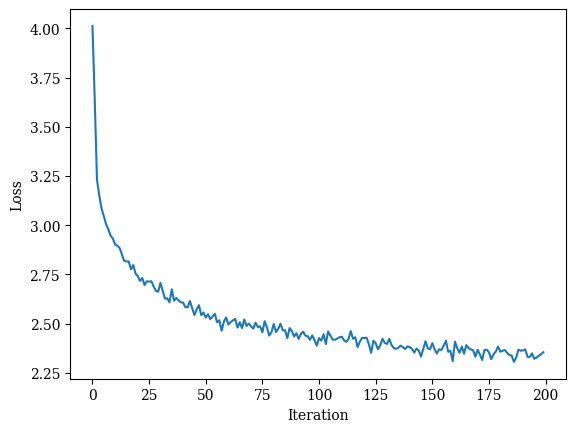

In [91]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)
plt.rc('font', family='serif')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [81]:
max_length = 20


# Sample from a category and starting letter
def sample(category, start_letter="A"):
    with torch.no_grad():  # no need to track history in sampling
        one_hot_categories = torch.eye(n_categories)
        one_hot_letters = torch.eye(n_letters)
        category_tensor = one_hot_categories[all_categories.index(category)].unsqueeze(
            0
        )
        input = one_hot_letters[letter_to_index[start_letter]].unsqueeze(0).unsqueeze(0)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = one_hot_letters[topi].unsqueeze(0).unsqueeze(0)

        return output_name


# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters="ABC"):
    print(f"Samples for [{category}]:")
    for start_letter in start_letters:
        print("\t", sample(category, start_letter))


samples("Russian", "RUS")

samples("German", "GER")

samples("Spanish", "SPA")

samples("Chinese", "CHI")

Samples for [Russian]:
	 Rakhanin
	 Uakhin
	 Shinov
Samples for [German]:
	 Gerter
	 Erer
	 Rour
Samples for [Spanish]:
	 Saran
	 Para
	 Anaran
Samples for [Chinese]:
	 Chan
	 Han
	 Ion
